In [1]:
import sys
print(sys.executable)
print(sys.prefix)

/opt/homebrew/Caskroom/miniforge/base/envs/torchLM/bin/python
/opt/homebrew/Caskroom/miniforge/base/envs/torchLM


In [4]:
import config.config_medgemma_4b_it_nih_cxr

/opt/homebrew/Caskroom/miniforge/base/envs/torchLM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
from huggingface_hub import login
# use login(token= ... to login in HF

In [3]:
import os
from datasets import load_dataset


import config.config_medgemma_4b_it_nih_cxr
import utils.load_data_chest_xray_pneumonia


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load the NIH Chest X-Ray Pneumonia Data

In [4]:
dataset = load_data_chest_xray_pneumonia()

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})


## Fine tune medgemma-4b-it on the NIH Chest X-Ray Pneumonia Data


In [5]:
from utils.data_utils import format_data_medgemma_nih_chest_x_ray
from utils.model_utils import load_model_and_processor
from config import config_medgemma_4b_it_nih_cxr
from peft_medgemma_4b_it_nih_pneumonia_chest_x_ray import fine_tune_medgemma_nih_pneumonia_chest_x_ray

# Format the dataset
formatted_dataset = dataset.map(format_data_medgemma_nih_chest_x_ray)



In [6]:
from utils.model_utils import download_model_and_processor
base_model, processor = download_model_and_processor(
    model_id=config_medgemma_4b_it_nih_cxr.base_model_id,
    save_directory=config_medgemma_4b_it_nih_cxr.model_folder_base,
    model_kwargs=config_medgemma_4b_it_nih_cxr.model_kwargs,
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor saved to /workspace/meda-main/models/medgemma-4b-it


In [7]:
# Load base model and processor
base_model, processor = load_model_and_processor(
    model_id=config_medgemma_4b_it_nih_cxr.base_model_id,
    model_directory=config_medgemma_4b_it_nih_cxr.model_folder_base,
    model_kwargs=config_medgemma_4b_it_nih_cxr.model_kwargs,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


In [8]:
# Fine-tune the model
fine_tune_medgemma_nih_pneumonia_chest_x_ray(
    model=base_model,
    processor=processor,
    data=formatted_dataset,
    base_model_directory=config_medgemma_4b_it_nih_cxr.model_folder_base,
    save_directory_adapters=config_medgemma_4b_it_nih_cxr.model_folder_pneumonia_ft_adapter,
    save_directory_full_model=config_medgemma_4b_it_nih_cxr.model_folder_pneumonia_ft_full,
    model_kwargs=config_medgemma_4b_it_nih_cxr.model_kwargs,
)

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,0.994700,0.032796,0.032043,260792.000000,0.981494
100,0.022000,0.024126,0.042883,521524.000000,0.984334
150,0.020900,0.020927,0.026594,782304.000000,0.985281
200,0.020700,0.056601,0.028480,1043144.000000,0.979600
250,0.021200,0.021702,0.027667,1303968.000000,0.985281
300,0.020600,0.021266,0.026758,1564684.000000,0.985281


Fine-tuned model adapters and processor saved to /workspace/meda-main/models/medgemma-4b-it-pneumonia-finetuned-adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


## Test the baseline model

In [12]:
import torch
import gc
torch.cuda.empty_cache()
del base_model, processor
gc.collect()


78235

In [13]:
from test_medgemma_49_it_nih_pneumonia_chest_x_ray import test_medgemma_4b_it_nih_pneumonia_chest_x_ray
from utils.prompt_utils import make_prompt_without_image


test_instance_base = test_medgemma_4b_it_nih_pneumonia_chest_x_ray(
    model_id=config_medgemma_4b_it_nih_cxr.base_model_id,
    model_folder=config_medgemma_4b_it_nih_cxr.model_folder_base,
    model_kwargs=config_medgemma_4b_it_nih_cxr.model_kwargs,
    max_new_tokens=250
)
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nih_cxr.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_nih_cxr.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_nih_cxr.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_nih_cxr.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_nih_cxr.condition_findings[dataset['test'][-7]['label']]}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it
System Message:You are a medical AI expert analyzing chest X-rays     for pneumonia detection.
User Message:Analyze this chest X-ray image for signs of pneumonia     or normal lungs. Do you detect: 
 A: NORMAL
B: PNEUMONIA
True finding:B: PNEUMONIA


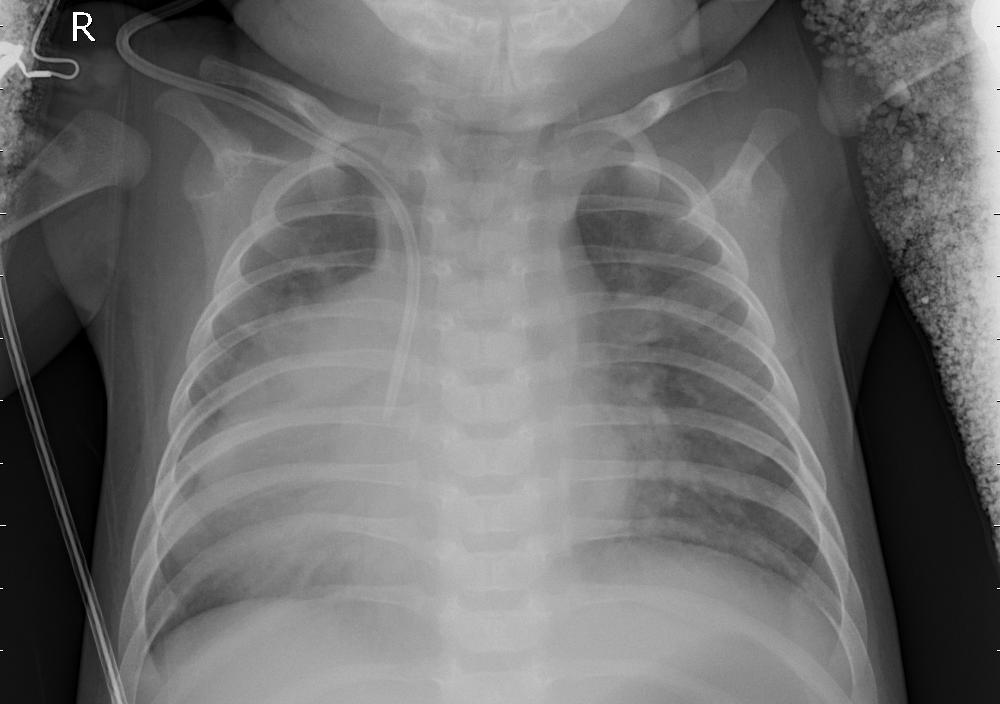

In [14]:
# dataset["test"][-7]["image"].show()
dataset["test"][-7]["image"]

In [15]:
base_assistant_message = test_instance_base.chat_v1(messages, dataset["test"][-7]["image"])

print(f"Baseline assistant message:{base_assistant_message}")

Generated Description: 
Based on the image provided, I would classify this as **A: NORMAL**.

Here's why:

*   **Lung Fields:** The lung fields appear relatively clear, without significant opacities or consolidation.
*   **Heart Size:** The heart size seems within normal limits.
*   **Mediastinum:** The mediastinum (the space between the lungs containing the heart, great vessels, etc.) appears normal.
*   **Other Structures:** The bony structures of the rib cage and clavicles are visible and appear intact.

While this is a preliminary assessment, and a definitive diagnosis requires a trained radiologist's interpretation, the image doesn't show any obvious signs of pneumonia.

Baseline assistant message:
Based on the image provided, I would classify this as **A: NORMAL**.

Here's why:

*   **Lung Fields:** The lung fields appear relatively clear, without significant opacities or consolidation.
*   **Heart Size:** The heart size seems within normal limits.
*   **Mediastinum:** The medias

## Test the fine-tuned model


In [16]:
test_instance_peft = test_medgemma_4b_it_nih_pneumonia_chest_x_ray(
    model_id="peft",
    model_folder=config_medgemma_4b_it_nih_cxr.model_folder_pneumonia_ft_full,
    model_kwargs=config_medgemma_4b_it_nih_cxr.model_kwargs,
    max_new_tokens=250
)
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nih_cxr.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_nih_cxr.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_nih_cxr.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_nih_cxr.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_nih_cxr.condition_findings[dataset['test'][-7]['label']]}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-pneumonia-finetuned-merged
System Message:You are a medical AI expert analyzing chest X-rays     for pneumonia detection.
User Message:Analyze this chest X-ray image for signs of pneumonia     or normal lungs. Do you detect: 
 A: NORMAL
B: PNEUMONIA
True finding:B: PNEUMONIA


In [17]:
ft_assistant_message = test_instance_peft.chat_v1(messages, dataset["test"][-7]["image"])
print(f"Fine-tuned assistant message:{ft_assistant_message}")

Generated Description: 
B: PNEUMONIA
Fine-tuned assistant message:
B: PNEUMONIA


## Test the augmented summary agent 

In [18]:
augmented_user_prompt = (config_medgemma_4b_it_nih_cxr.prompt_template["user_prompt"]
                             + f"\nIn your answer, please consider that a fine-tuned model ML model on a pneumonia"
                               f"\nchest X-ray dataset does predict the label **{ft_assistant_message}**  in this case. "
                               f"\nProvide a detailed explanation for your diagnosis.")
    
augmented_messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_nih_cxr.prompt_template["system_message"],
        user_prompt=augmented_user_prompt)
# augmented_assistant_message = test_instance_base.chat(augmented_messages)
augmented_assistant_message = test_instance_base.chat_v1(augmented_messages, dataset["test"][-7]["image"])

print(f"Augmented-tuned assistant message:{augmented_assistant_message}")

Generated Description: 
Based on the chest X-ray image, I detect **B: PNEUMONIA**.

Here's a detailed explanation:

The image shows a chest X-ray of a baby. There are several findings that suggest pneumonia:

*   **Increased Opacity in the Right Lung:** There appears to be increased density or opacity in the right lung field, particularly in the lower portion. This could be due to consolidation, fluid accumulation, or inflammation, all of which are characteristic of pneumonia.
*   **Possible Consolidation:** The increased opacity in the right lung could represent consolidation, where the air spaces in the lung are filled with fluid or inflammatory exudate.
*   **Possible Infiltrates:** The hazy appearance in the right lung could also be indicative of infiltrates, which are areas of inflammation and fluid accumulation within the lung tissue.

It's important to note that this is a preliminary assessment based on a single image. A definitive diagnosis requires a comprehensive evaluation b

In [19]:
import torch
import gc
torch.cuda.empty_cache()
del test_instance_peft, test_instance_base
gc.collect()

5898

## Evaluate and compare baseline and expert

In [5]:
from evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray import evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray

ModuleNotFoundError: No module named 'src'

In [22]:
from evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray import evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray

model_kwargs = config_medgemma_4b_it_nih_cxr.model_kwargs
evaluator = evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray(
    model_id=config_medgemma_4b_it_nih_cxr.base_model_id,
    model_folder=config_medgemma_4b_it_nih_cxr.model_folder_base,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

dataset = load_data_chest_xray_pneumonia()
dataset_test = dataset["test"]
#dataset_test = dataset_test.select(list(range(10)) + list(range(len(dataset_test)-10, len(dataset_test), 1)))
accuracy_baseline, f1_baseline = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Base Model Evaluation - Accuracy: {accuracy_baseline}, F1 Score: {f1_baseline}")

del evaluator
gc.collect()
torch.clear_autocast_cache()

evaluator = evaluate_medgemma_4b_it_nih_pneumonia_chest_x_ray(
    model_id="peft",
    model_folder=config_medgemma_4b_it_nih_cxr.model_folder_pneumonia_ft_full,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

accuracy_ft, f1_ft = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Fine tuned Model Evaluation - Accuracy: {accuracy_ft}, F1 Score: {f1_ft}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})
Accuracy: 0.48717948717948717)
F1 Metric: 0.4159042927515834)
Base Model Evaluation - Accuracy: 0.48717948717948717, F1 Score: 0.4159042927515834


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-pneumonia-finetuned-merged
Accuracy: 0.8990384615384616)
F1 Metric: 0.895134054170915)
Fine tuned Model Evaluation - Accuracy: 0.8990384615384616, F1 Score: 0.895134054170915


In [23]:
del evaluator
gc.collect()
torch.clear_autocast_cache()